# Data Science Project: Digital Media Consumption & Sharing
Miles McCain

CSC630 — Machine Learning (Fall 2018)

---

The Internet turned traditional media publishing on its head. Nowadays, the media we consume is served to us by algorithms instead of editorial boards. I don't claim that this development is an improvement or a step backward from the non-digital status quo; it's just radically different. Shares, page-views, and hits—these are the numbers which rule the modern newsroom. _How can newsrooms optimize the number of 'shares' their articles will receive? Are there clear patterns in article 'virality'?_ These are all questions I will attempt to answer—albeit with a narrowed scope—in this analysis.

Published on the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), the [Online News Popularity](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity) dataset provides a sample of online news articles' attributes and metadata (words in the title, number of 'positive' words in the title, day of the week that the article is published, etc) and popularity (as indicated by the total number of times that the article is 'shared' on social media). The articles were collected from Mashable over a period of two years between 2013 and 2015. The dataset is cited below.

> K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

### Features

The dataset has sixty features and one response (number of shares). Two of its features (`url`, the article's url, and `timedelta`, the time between the article being published and the original authors pulling it into their dataset) are non-predictive.

Conveniently, the dataset authors have already engineered a number of useful features to aid analysis. These features include `n_tokens_title` (the total number of words in the title of the article), `n_tokens_content` (the total number of words in the body of the article), `n_non_stop_words` (the 'rate' of non-stop words in the article text), `num_videos` (the number of videos in the article), channel data (which channels—for example, tech, world, business, lifestyle, etc—was the article published under), time features such as `is_weekend` (was the article published on the weekend), and dozens of other features.

*For a complete list and explanation of the dataset's figures and response, as described by the dataset authors themselves, see the Appendix.*

### Response

The response of the dataset is `shares`, which denotes the number of times that the article was shared on social media at the time that the authors pulled the article into their dataset. 

### Samples
The dataset contains 39,644 samples. There is no missing data.

### A Note on Terminology
Because the target is 'shares' (as defined by Fernandes et al.) and the number of times an article is shared is analogous to how _popular_ an article is, the adjective 'popular' is used throughout this analysis to refer to articles which have been shared a large number of times.

### Models
We will try using the following models in the analysis.

* Linear Regression
* Decision Tree Regressor
* Random Forest Regressor

### Results
In line with the findings of other researers, no model achieved an r-squared accuracy greater than `0.2`. However, every model correctly classified whether an article would be shared more or less times than the median share value in a majority of cases. These findings indicate that online news popularity cannot be accurately predicted using the given features: after all, the dataset consists largely of noise and contains only a small amount of signal.

---

With the summary out of the way, let's begin!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import zipfile
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)
plt.style.use("fivethirtyeight")

## Loading the data

Let's load the data directly from the source! No need to fiddle with downloading external files.

In [2]:
# I used https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3 for help understanding how to
# zip and unzip files in Python.
urllib.request.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip", "OnlineNewsPopularity.zip")
zipped_file = zipfile.ZipFile("OnlineNewsPopularity.zip", "r")
zipped_file.extractall(".")
zipped_file.close()

## A First Look

We'll start by loading the data into a DataFrame.

In [3]:
df = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv")

Now, let's take a first look at the data!

In [4]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Data Cleaning

Generally, this is a very mature dataset. The authors already did much of our work for us—for example, they already performed 'one-hotting' on all the categorical features. It looks like some of the column names are prepended with spaces, so let's remove those before moving forward.

In [5]:
df.rename(columns={column: column.strip() for column in df.columns}, inplace=True)

There's also a typo in one of the column names, so we'll go ahead and fix that too.

In [6]:
df.rename(columns={"self_reference_avg_sharess": "self_reference_average_shares"}, inplace=True)

Let's also drop the columns that, for transparency purposes, we won't use in our analysis. After all, if we can't explain what it means, we shouldn't be using it in our predictions.

We'll also drop `url` and `timedelta`, because these aren't predictive features.

In [7]:
df.drop(['url', 'timedelta', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'], axis=1, inplace=True)

With that done, let's look for missing values or suspicious samples that we should omit.

In [8]:
df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_average_shares,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,0.052946,0.178009,0.157855,0.058597,0.185299,0.212567,26.106801,1153.951682,312.366967,13612.354102,752324.066694,259281.938083,1117.146610,5657.211151,3135.858639,3998.755396,10329.212662,6401.697580,0.168020,0.186409,0.187544,0.183306,0.143805,0.061876,0.069039,0.130915,0.443370,0.119309,0.039625,0.016612,0.682150,0.287934,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,0.223929,0.382525,0.364610,0.234871,0.388545,0.409129,69.633215,3857.990877,620.783887,57986.029357,214502.129573,135102.247285,1137.456951,6098.871957,1318.150397,19738.670516,41027.576613,24211.332231,0.373889,0.389441,0.390353,0.386922,0.350896,0.240933,0.253524,0.337312,0.116685,0.096931,0.017429,0.010828,0.190206,0.156156,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,141.750000,0.000000,843300.000000,172846.875000,0.000000,3562.101631,2382.448566,639.000000,1100.000000,981.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396167,0.057757,0.028384,0.009615,0.600000,0.185185,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,660.0000

In [9]:
df.dropna().equals(df)

True

It looks like there are no NaNs: even after we dropped them, our dataset didn't change. Plus, `df.describe()` above did not indicate any 'suspicious' minimums and maximums. Because the dataset description did not mention missing values, there are no NaNs, and this dataset is popularly known to not have any missing values, we can be confident that our data is reliable. 

## Preliminary Analysis & Feature Engineering

Now that we have cleaned our data, let's take a closer look at what we're working with.

### The Target: Shares

Why don't we start by examining our target, `shares`.

/home/miles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


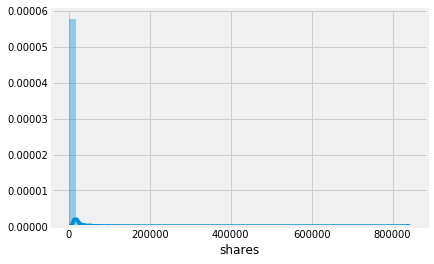

In [10]:
sns.distplot(df['shares'])

Wow, that's quite the range. Some articles receive barely any shares, and others receive nearly 100,000. This might throw our models off.

We might consider instead trying to predict the _logarithm_ of the shares. That way, our data will be slightly more compact—and less confusing for the models. (Here, I cite [this article](https://www.linkedin.com/pulse/online-news-popularity-trend-analysis-krunal-khatri/) as the inspiration for this idea. In the author's analysis, they also take the log of `shares` to dampen the effect of extreme values.)

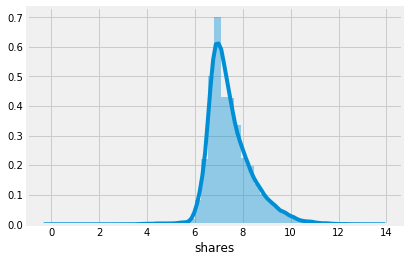

In [11]:
sns.distplot(np.log(df['shares']))

Okay, perfect! That looks a lot better. Let's make it official, so to speak:

In [12]:
df['shares_log'] = np.log(df['shares'])

We'll also perform min/max scaling later on, but taking the logarithm can help to more effectively normalize the data.

### Detecting Correlations and Feature Overlap

Now, let's take a look at some correleations before we embark on the rest of our feature engineering. We'll start by looking at the correlations between _all_ of the features. This will help us understand if any features are indicating the same thing, and should therefore be omitted.

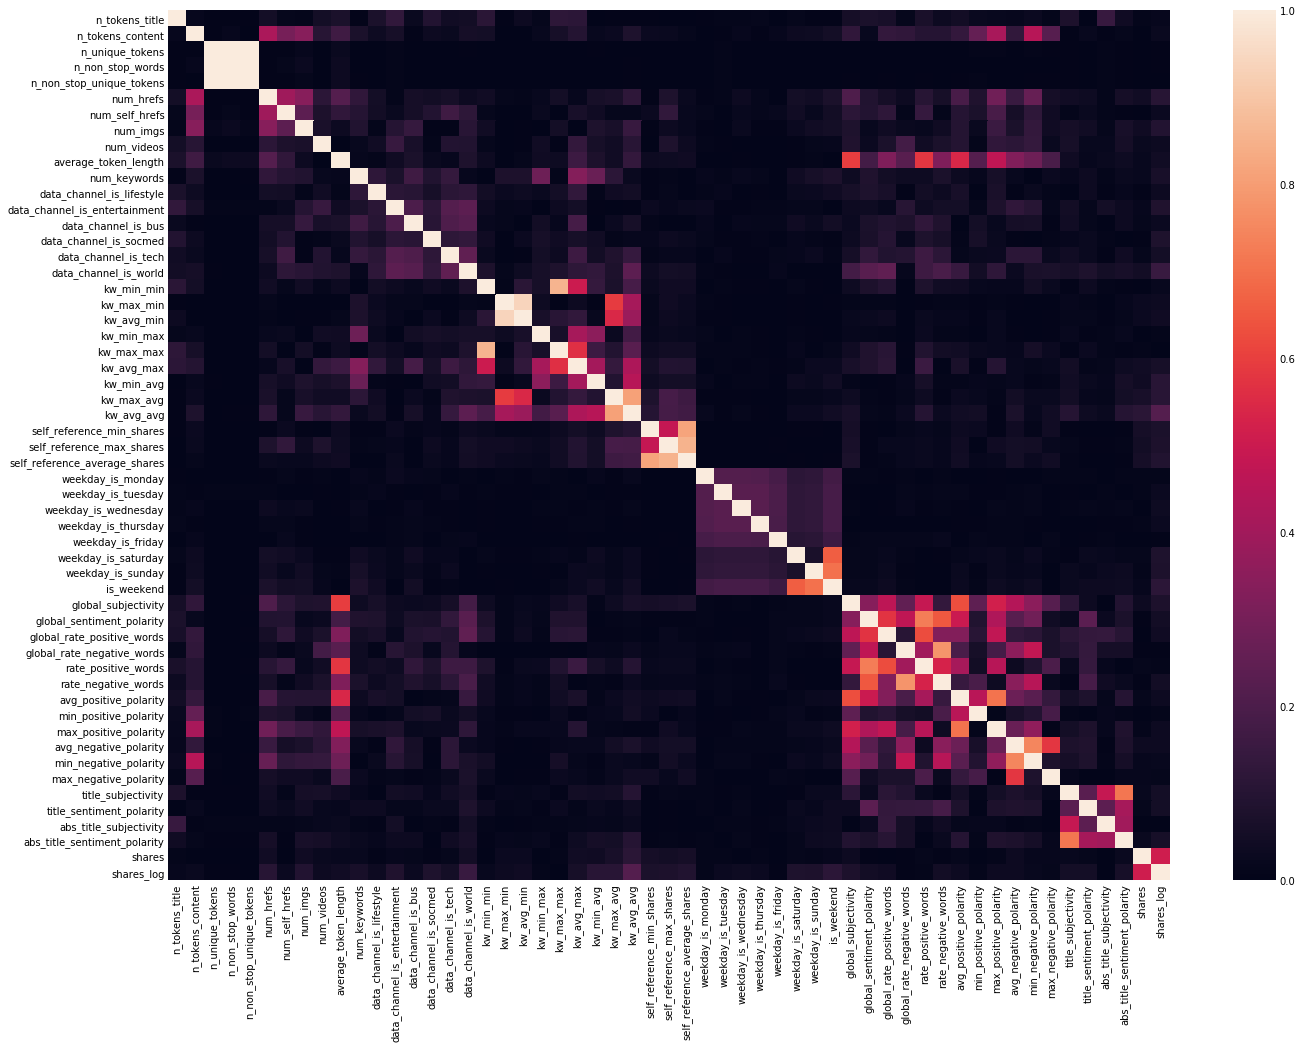

In [13]:
correlation = df.corr().abs()
plt.figure(figsize = (20, 16))
sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

That's a helpful visual, and it helps us identify many overlapping features. Notably, it doesn't look like there are any features that really correlate well with `shares` or `shares_log`.

Let's have a look at the features which contain the _most_ shared data (as visualized in the chart above).

In [14]:
# The following line is from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
upper_triangle = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]
print(highly_correlated)

['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min', 'kw_max_max', 'kw_avg_avg', 'self_reference_average_shares', 'rate_negative_words']


Perfect. Let's look at a few scatterplots to confirm our hypothesis that these features are redundant to others.

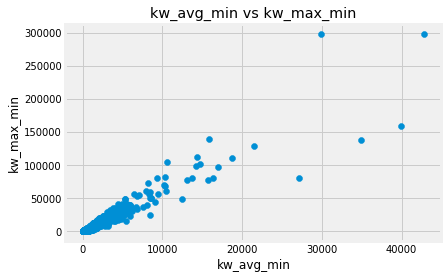

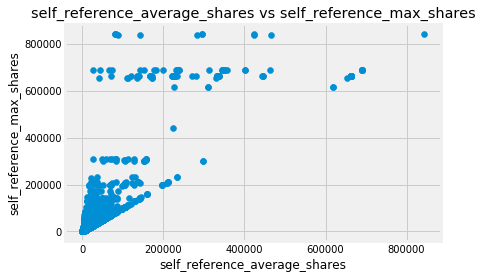

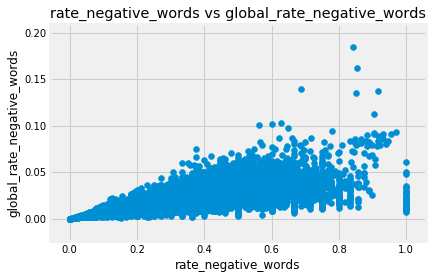

In [15]:
def smart_scatter_comparison(data, x, y):
    plt.scatter(data[x], data[y])
    plt.title("%s vs %s" % (x, y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
smart_scatter_comparison(df, "kw_avg_min", "kw_max_min")
smart_scatter_comparison(df, "self_reference_average_shares", "self_reference_max_shares")
smart_scatter_comparison(df, "rate_negative_words", "global_rate_negative_words")

It looks like they are certainly correlated, so let's drop those columns and look at our updated correlation heatmap!

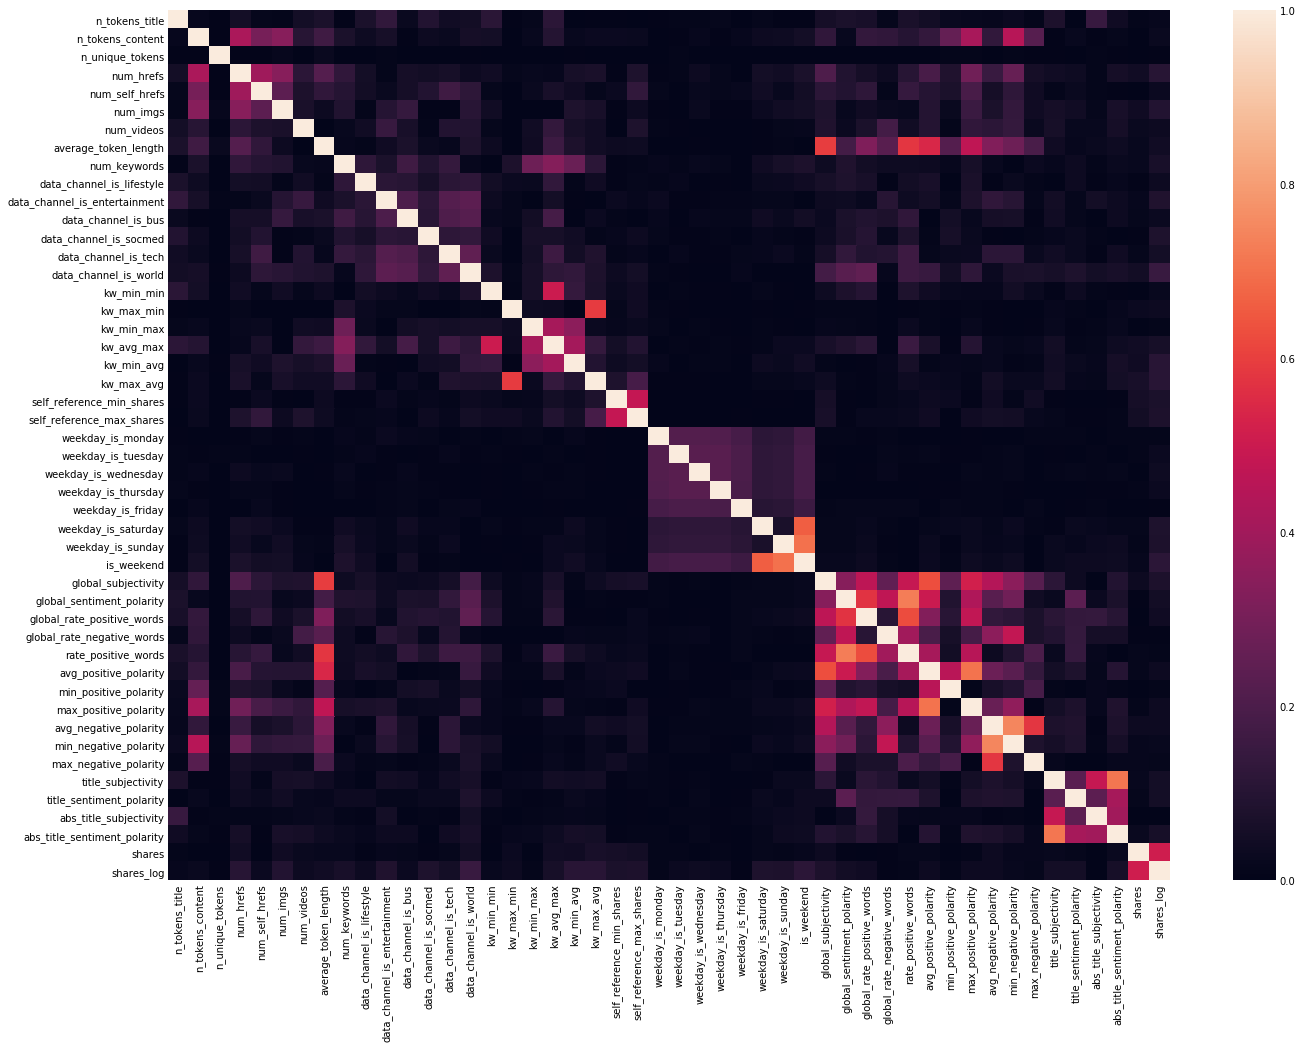

In [16]:
df.drop(highly_correlated, inplace=True, axis=1)
correlation = df.corr().abs()
plt.figure(figsize = (20, 16))
sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

### Reducing Spread (Normalization)

Now that we've reduced the feature overlap, we'll also need to make sure that our data isn't too spread out (and might therefore not lend itself well to fitting). This is also known as _scaling_. Because we don't want our scaling function to 'see' our test data and fit according to it, we will perform our normalization _after_ we create our test-train split.

### Finalizing our Features

Now that our data is cleaned and our features are engineered, let's establish the final features and target.

In [17]:
features = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
           'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
           'num_keywords', 'data_channel_is_lifestyle',
           'data_channel_is_entertainment', 'data_channel_is_bus',
           'data_channel_is_socmed', 'data_channel_is_tech',
           'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
           'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares',
           'self_reference_max_shares', 'weekday_is_monday', 'weekday_is_tuesday',
           'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
           'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend',
           'global_subjectivity', 'global_sentiment_polarity',
           'global_rate_positive_words', 'global_rate_negative_words',
           'rate_positive_words', 'avg_positive_polarity', 'min_positive_polarity',
           'max_positive_polarity', 'avg_negative_polarity',
           'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
           'title_sentiment_polarity', 'abs_title_subjectivity',
           'abs_title_sentiment_polarity']
target = 'shares_log'

### PCA Analysis

Let's figure out if PCA can work its magic on this dataset. I would suspect that PCA won't be hugely helpful—after all, each feature in this dataset is largely independent (unlike drawn digits, where each feature is a pixel). This all aside, let's see what we can find out.

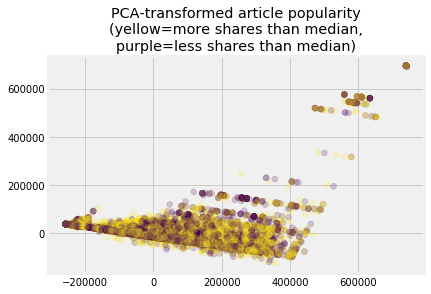

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df[features], df[target])

color_threshold = df['shares'].median()
plt.scatter([sample[0] for sample in pca_transformed], [sample[1] for sample in pca_transformed], alpha=0.2, c=df['shares'].map(lambda k: k > color_threshold))
plt.title("PCA-transformed article popularity\n(yellow=more shares than median,\npurple=less shares than median)")
plt.show()

This is interesting, but not hugely helpful. There is no clear clustering of 'popular' articles and 'unpopular' articles. This might indicate that there might not be huge correlations here, and that we might have a difficult time with the models below.

One 'hack' often used on Kaggle is just appending PCA transformations as features, but I'm not going to do that here. We should either use the PCA transformation or the original data—not _both_.

For good measure, we will also look at the ratio of explained variance for the components, and then decide whether to use PCA.

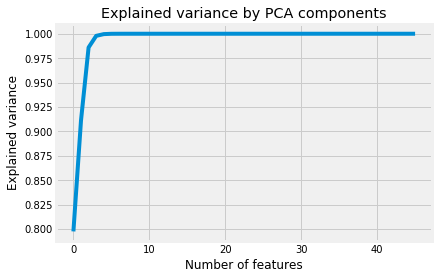

In [19]:
pca = PCA(n_components=len(features)).fit(df[features])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of features")
plt.ylabel("Explained variance")
plt.title("Explained variance by PCA components")
plt.show()

That's quite interesting! Most of the variance can be explained in 4 dimensions. That being said, I'm still not going to use PCA. Because the dataset is mostly noise (see below) PCA just isn't appropriate in this dataset, as one of its assumptions is that the data is _mostly_ signal.

## Training the Models

We will use the following models in the analysis:

* Linear Regression
* Decision Tree Regressor
* Random Forest Regressor

In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

### Test-train split

Because we have so much data, we're going to go with a typical test-train split of 75%-25%.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25)

### Data Scaling

Because we didn't want to fit our scaling preprocessor on the test data, we perform our scaling here separately to each dataset. We're careful to _fit_ the scaler on the training data, but only to _transform_ the test data.

In [22]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()

X_train = pd.DataFrame(transformer.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test), index=X_test.index, columns=X_test.columns)

### Linear Regression

In [23]:
linear_regression = LinearRegression().fit(X_train, y_train)

Okay, the model is fit. Let's take a look at its r-squared accuracy.

In [24]:
r2_score(y_test, linear_regression.predict(X_test))

-0.6834725840654308

Wow, that's quite poor. But let's think about this in context: I imagine that news popularity is largely hit or miss. _Any_ r-squared greater than 0 is something to be proud of!

Let's see what happens when we look at whether the model can somewhat consistently predict whether articles will be _more_ or _less_ popular than the median popularity.

In [25]:
popularity_threshold = df[target].median()
def accuracy_on_median(model, X_test_data, y_test_data):
    predicted = model.predict(X_test_data) # broadcasting!
    return accuracy_score(y_test_data > popularity_threshold, predicted > popularity_threshold)

In [26]:
accuracy_on_median(linear_regression, X_test, y_test)

0.6002421551811119

Interesting! In a majority of cases, the model accurately predicts whether the article will be _more popular_ or _less popular_ than the mean. **I realize that this is akin to 'casting' a regression problem into a classification one, but it nonetheless provides a sanity check that our model is indeed doing _something_.**

With all that aside, let's see if a decision-tree based model can perform any better.

### Decision Tree Regressor

While it's unlikely to be an effective model for our data, for thoroughness we will also train and visualize a _decision tree_.

In [27]:
decision_tree = DecisionTreeRegressor(max_depth=2).fit(X_train, y_train)
# Making depth 2 for the sake of the visualization below

In [28]:
r2_score(y_test, decision_tree.predict(X_test))

0.06610201576216157

Terrible! But... not as terrible as I would have expected. Let's look at its accuracy with respect to the median, as we did above.

In [29]:
accuracy_on_median(decision_tree, X_test, y_test)

0.5915649278579356

Surprisingly, when considered from this perspective, the decision tree appears slightly better. In fact, it's almost as good as our linear regression! For purely exploratory purposes, let's _visualize_ our rudimentary tree.

(If you don't have `graphviz` installed, you can install it with `pip install graphviz`. I used [this](https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn) StackOverflow answer for help with the below.)

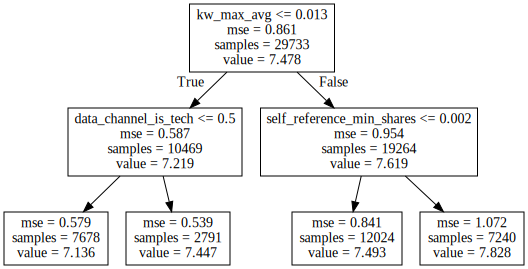

In [30]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X_train.columns))

It's fascinating that a model so simple (as shown above) is nearly as powerful as our more advanced models.

### Random Forest Regressor

A random forest is hundreds of different decision trees combined in the form of an _ensemble_, the hope being that the model will be less overfit to the training data. Let's examine how a random forest regressor performs on this data.

In [31]:
random_forest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

In [32]:
r2_score(y_test, random_forest.predict(X_test))

0.14463433761795197

Like above, let's look at the accuracy with respect to the median to assess our accuracy.

In [33]:
accuracy_on_median(random_forest, X_test, y_test)

0.6261729391585108

Somewhat better than the linear regression and the decision tree, but only barely.

## Optimizing Popularity

Although none of the models are incredibly effective at predicting whether articles will be popular, the fact that each model is able to predict whether an article will be more or less popular than the median popularity indicates that there is _some_ signal in the data.

Let's pick apart our linear regression and learn more about which features matter, which do not, and how they affect news popularity. (Keep in mind that because all the features were scaled to fit between 0 and 1, the following values _are_ comparable to one another.)

In [34]:
sorted_importance = sorted(zip(features, linear_regression.coef_), key=lambda k: np.abs(k[1]))

print("Least important features ---------------")
print(*sorted_importance[:8], sep="\n")
print()
print("Most important features ---------------")
print(*sorted_importance[-8:], sep="\n")

Least important features ---------------
('weekday_is_friday', -0.0013580575810263555)
('min_negative_polarity', 0.001492598341510241)
('weekday_is_monday', 0.007011376172337537)
('max_positive_polarity', -0.02091744896049976)
('data_channel_is_tech', -0.02973430588496162)
('n_tokens_title', 0.0327385135344096)
('weekday_is_thursday', -0.04466347919907916)
('abs_title_sentiment_polarity', 0.045502711303200875)

Most important features ---------------
('self_reference_max_shares', 0.5350444061938702)
('global_subjectivity', 0.5587184406061532)
('average_token_length', -0.7218780253706275)
('num_self_hrefs', -1.1028164961205973)
('num_hrefs', 1.7219171426606739)
('self_reference_min_shares', 1.80141357891441)
('kw_max_min', -2.22609846493225)
('kw_max_avg', 3.209096118297688)


Starting with the **least important features**, we find that whether an article is published on a Monday or Friday has virtually no effect on the linear regression's predictions—and therefore is unlikely to affect whether an article is going to be popular. The minimum negative polarity of words in the content of the article also has little effect, as with the average positive polarity of words in the content. Whether the article is published in the tech channel also doesn't seem to matter. For more information about these and other features, see the Appendix.

The **features with the greatest effect** on the data are the popularity of the article's least popular keyword (negatively correlated); the miniumum number of shares of the Mashable articles linked to by the article (positively correlated); the number of links in the article (positively correlated); the rate of unique words in the article (positively correlated); and the average popularity of the article's most popular keyword.

**What does this mean for news publishers?** If they wish to maximize the popularity of their articles, they should use lots of unique words in the article (i.e. use advanced language), link to lots of other articles (especially their most popular articles), and use keywords that have been traditionally popular on their platform.

## The takeaway: a perfect fit isn't always possible.

If there's a single takeaway from this analysis, it's that machine learning isn't always a 'silver bullet' that can beautifully fit a model to a dataset. In a dataset such as this one, there is a lot of noise—perhaps it's even _mostly_ noise—and no degree of feature engineering, selection, and reduction can possibly create an effective model. We did find _some_ signal: all the models correctly predicted whether the article was going to be more or less popular than the median popularity in a majority of cases. Still, our r-squared value never surpassed `0.2`. In other words, we did slightly better than a monkey choosing randomly would—but only slightly. (For what it's worth, this is in line with what other researchers have been able to [accomplish](https://medium.com/@syedsadiqalinaqvi/predicting-popularity-of-online-news-articles-a-data-scientists-report-fac298466e7) on this same dataset.)

Fortunately, a nearly-null finding is a finding in and of itself. While this analysis did not fail to create somewhat accurate models—60% of samples correctly classified is _decent_—it also didn't uncover the secret to producing viral news articles. As we saw above, certain features can be tweaked to increase the likelihood of an article going viral, but there's no magic solution. Machine learning can't predict everything.

Yet!

---

# Appendix

For detailed features about each of the following features, see the dataset authors' original paper:

> K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

The features are summarized below, as described by the dataset myself. (Because I do not want to introduce errors, I include the original wording below and format it as a quote.)

> 0. **`url`**: URL of the article
> 1. **`timedelta`**: Days between the article publication and the dataset acquisition
> 2. **`n_tokens_title`**: Number of words in the title
> 3. **`n_tokens_content`**: Number of words in the content
> 4. **`n_unique_tokens`**: Rate of unique words in the content
> 5. **`n_non_stop_words`**: Rate of non-stop words in the content
> 6. **`n_non_stop_unique_tokens`**: Rate of unique non-stop words in the content
> 7. **`num_hrefs`**: Number of links
> 8. **`num_self_hrefs`**: Number of links to other articles published by Mashable
> 9. **`num_imgs`**: Number of images
> 10. **`num_videos`**: Number of videos
> 11. **`average_token_length`**: Average length of the words in the content
> 12. **`num_keywords`**: Number of keywords in the metadata
> 13. **`data_channel_is_lifestyle`**: Is data channel 'Lifestyle'?
> 14. **`data_channel_is_entertainment`**: Is data channel 'Entertainment'?
> 15. **`data_channel_is_bus`**: Is data channel 'Business'?
> 16. **`data_channel_is_socmed`**: Is data channel 'Social Media'?
> 17. **`data_channel_is_tech`**: Is data channel 'Tech'?
> 18. **`data_channel_is_world`**: Is data channel 'World'?
> 19. **`kw_min_min`**: Worst keyword (min. shares)
> 20. **`kw_max_min`**: Worst keyword (max. shares)
> 21. **`kw_avg_min`**: Worst keyword (avg. shares)
> 22. **`kw_min_max`**: Best keyword (min. shares)
> 23. **`kw_max_max`**: Best keyword (max. shares)
> 24. **`kw_avg_max`**: Best keyword (avg. shares)
> 25. **`kw_min_avg`**: Avg. keyword (min. shares)
> 26. **`kw_max_avg`**: Avg. keyword (max. shares)
> 27. **`kw_avg_avg`**: Avg. keyword (avg. shares)
> 28. **`self_reference_min_shares`**: Min. shares of referenced articles in Mashable
> 29. **`self_reference_max_shares`**: Max. shares of referenced articles in Mashable
> 30. **`self_reference_avg_sharess`**: Avg. shares of referenced articles in Mashable
> 31. **`weekday_is_monday`**: Was the article published on a Monday?
> 32. **`weekday_is_tuesday`**: Was the article published on a Tuesday?
> 33. **`weekday_is_wednesday`**: Was the article published on a Wednesday?
> 34. **`weekday_is_thursday`**: Was the article published on a Thursday?
> 35. **`weekday_is_friday`**: Was the article published on a Friday?
> 36. **`weekday_is_saturday`**: Was the article published on a Saturday?
> 37. **`weekday_is_sunday`**: Was the article published on a Sunday?
> 38. **`is_weekend`**: Was the article published on the weekend?
> 39. **`LDA_00`**: Closeness to LDA topic 0
> 40. **`LDA_01`**: Closeness to LDA topic 1
> 41. **`LDA_02`**: Closeness to LDA topic 2
> 42. **`LDA_03`**: Closeness to LDA topic 3
> 43. **`LDA_04`**: Closeness to LDA topic 4
> 44. **`global_subjectivity`**: Text subjectivity
> 45. **`global_sentiment_polarity`**: Text sentiment polarity
> 46. **`global_rate_positive_words`**: Rate of positive words in the content
> 47. **`global_rate_negative_words`**: Rate of negative words in the content
> 48. **`rate_positive_words`**: Rate of positive words among non-neutral tokens
> 49. **`rate_negative_words`**: Rate of negative words among non-neutral tokens
> 50. **`avg_positive_polarity`**: Avg. polarity of positive words
> 51. **`min_positive_polarity`**: Min. polarity of positive words
> 52. **`max_positive_polarity`**: Max. polarity of positive words
> 53. **`avg_negative_polarity`**: Avg. polarity of negative words
> 54. **`min_negative_polarity`**: Min. polarity of negative words 
> 55. **`max_negative_polarity`**: Max. polarity of negative words
> 56. **`title_subjectivity`**: Title subjectivity
> 57. **`title_sentiment_polarity`**: Title polarity
> 58. **`abs_title_subjectivity`**: Absolute subjectivity level
> 59. **`abs_title_sentiment_polarity`**: Absolute polarity level
> 60. **`shares`**: Number of shares (target)